# Value Investor

- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: May 10, 2023

## Import libraries & Data

In [1]:
import zipfile

local_zip = './data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os

filenames = os.listdir('data')

# We will store the stock data for all companies by their company code
stock_dfs = {}

In [4]:
def get_company_code(name):
  return name[name.find("(")+1:name.find(")")]

get_company_code('2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv')

'PAMP'

In [5]:
for fname in filenames:
  stock_dfs[get_company_code(fname)] = pd.read_csv(os.path.join('./data', fname))

In [6]:
stock_dfs['PAMP'].head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",85.15,86.5,88.1,85.15,564.30K,-1.10%
1,"Mar 30, 2021",86.1,85.15,86.75,84.6,141.40K,1.29%
2,"Mar 29, 2021",85,80,86,79,371.22K,3.85%
3,"Mar 26, 2021",81.85,84,84.6,80.7,462.55K,-2.09%
4,"Mar 25, 2021",83.6,85.2,87.3,82.1,389.78K,-3.13%


In [7]:
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      301 non-null    object
 1   Price     301 non-null    object
 2   Open      301 non-null    object
 3   High      301 non-null    object
 4   Low       301 non-null    object
 5   Vol.      300 non-null    object
 6   Change %  300 non-null    object
dtypes: object(7)
memory usage: 16.6+ KB


## Data Preprocessing

We notice that the last row of the datasets stores a summary of the stock price change which should be discarded for modelling in the future.

In [8]:
stock_dfs['PAMP'].tail()

,Date,Price,Open,High,Low,Vol.,Change %
296,"Jan 07, 2020",47.6,48.35,49,46.9,901.95K,-1.86%
297,"Jan 06, 2020",48.5,48.4,48.7,47,719.24K,-0.61%
298,"Jan 03, 2020",48.8,48.25,49.45,46.5,595.36K,1.14%
299,"Jan 02, 2020",48.25,49.35,50.2,47.55,878.50K,-2.92%
300,Highest: 90.000,Lowest: 32.000,Difference: 58.000,Average: 61.244,Change %: 71.328,NaN,NaN


In [9]:
for code in stock_dfs:
  df = stock_dfs[code]
  df.drop(df.tail(1).index,inplace=True)

In [10]:
# The last row is successfully removed
stock_dfs['PAMP'].tail()

,Date,Price,Open,High,Low,Vol.,Change %
295,"Jan 08, 2020",46.5,47.5,47.5,46,1.18M,-2.31%
296,"Jan 07, 2020",47.6,48.35,49,46.9,901.95K,-1.86%
297,"Jan 06, 2020",48.5,48.4,48.7,47,719.24K,-0.61%
298,"Jan 03, 2020",48.8,48.25,49.45,46.5,595.36K,1.14%
299,"Jan 02, 2020",48.25,49.35,50.2,47.55,878.50K,-2.92%


Now we need to convert the `Price` to numerical representation.

In [11]:
for code in stock_dfs:
  df = stock_dfs[code]
  df['Price'] = df['Price'].apply(lambda x: float(''.join(x.split(','))))

We notice that the `Date` is currently stored as string. It might be helpful to convert them into datetime for further uses.

In [12]:
from datetime import datetime

for code in stock_dfs:
  df = stock_dfs[code]
  df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

In [13]:
# the Date column has successfully been transformed
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      300 non-null    datetime64[ns]
 1   Price     300 non-null    float64       
 2   Open      300 non-null    object        
 3   High      300 non-null    object        
 4   Low       300 non-null    object        
 5   Vol.      300 non-null    object        
 6   Change %  300 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 16.5+ KB


To represent the dates numerically, we can calculate how many days after was a data point recorded from the baseline date, for which we will choose Jan 1, 2020.

In [14]:
for code in stock_dfs:
  df = stock_dfs[code]
  df['date_diff'] = df['Date'].apply(lambda x: (x - datetime.strptime('Jan 01, 2020', '%b %d, %Y')).days)
  df.sort_values(by='date_diff', ascending=True, inplace=True)

In [15]:
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 299 to 0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       300 non-null    datetime64[ns]
 1   Price      300 non-null    float64       
 2   Open       300 non-null    object        
 3   High       300 non-null    object        
 4   Low        300 non-null    object        
 5   Vol.       300 non-null    object        
 6   Change %   300 non-null    object        
 7   date_diff  300 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 21.1+ KB


Now we can visualize how the price changed for each company.

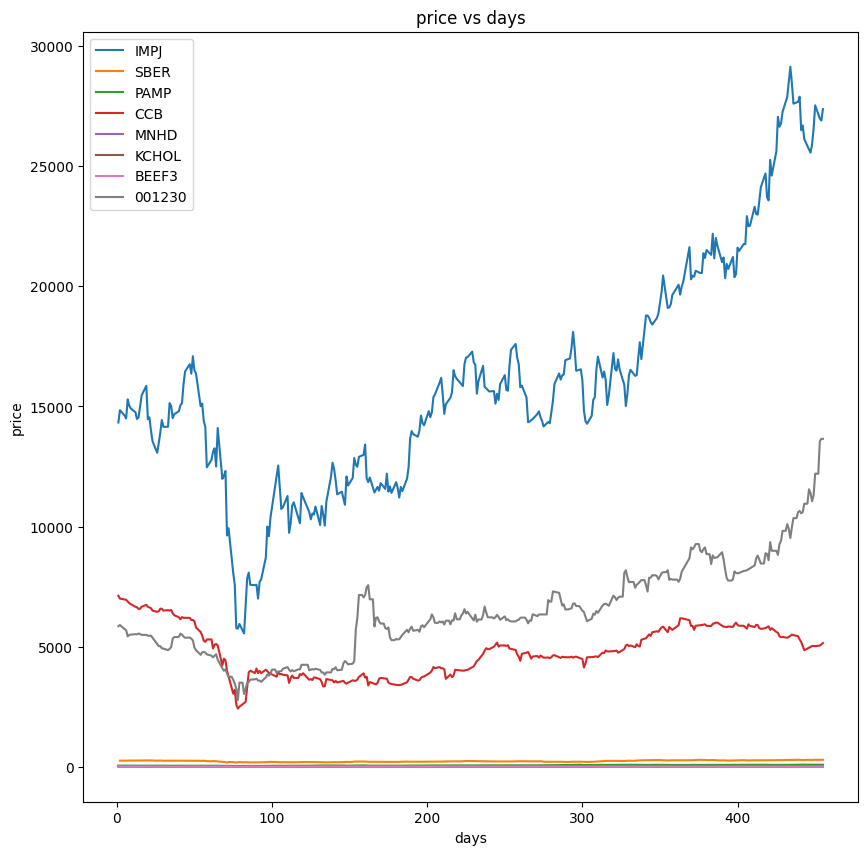

In [16]:
plt.figure(figsize=(10,10))

for code in stock_dfs:
  df = stock_dfs[code]
  plt.plot(df['date_diff'], df['Price'], label = code)

plt.xlabel('days')
plt.ylabel('price')
plt.title('price vs days')
plt.legend()
plt.show()

Out of the 8 stocks that we have, IMPJ, 001230 and CCB are significantly more expensive comparing to the others. We can exclude these 3 and see how the others perform.

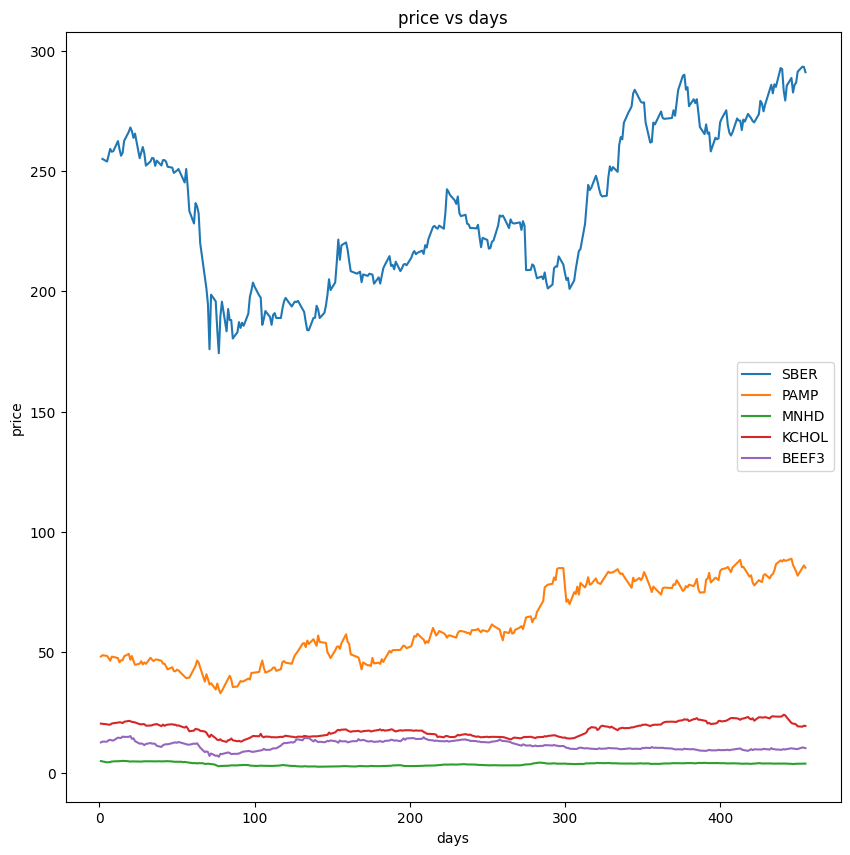

In [17]:
plt.figure(figsize=(10,10))

for code in stock_dfs:
  if code in ['IMPJ', '001230', 'CCB']:
    continue
  df = stock_dfs[code]
  plt.plot(df['date_diff'], df['Price'], label = code)

plt.xlabel('days')
plt.ylabel('price')
plt.title('price vs days')
plt.legend()
plt.show()

It seems that MNHD is performing stably at the low price range that is below 5 whereas the other stocks flunctuates a bit more.

We will pick 'PAMP' for our initial attempt of modelling.

## Preparing the datasets

In [18]:
from pandas.core import window
# We will define a helper function to transform our data into batches padded to the same length
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

# Training set: price from 2020, Testing set: price from 2021
def train_test_split(df):
  series = df['Price']

  # Get the index of the first data point in 2021
  idx_2021 = df['Date'].apply(lambda x: x.year == 2021).argmax()

  time_train = df['Date'].values[:idx_2021]
  time_test = df['Date'].values[idx_2021:]
  
  train_set = series[:idx_2021].values
  test_set = series[idx_2021-WINDOW_SIZE:].values

  return idx_2021, time_train, train_set, time_test, test_set

df = stock_dfs['PAMP']
idx_2021, time_train, train_set, time_test, test_set = train_test_split(df)

In [19]:
def windowing(series, window_size = WINDOW_SIZE):
    data = []
    labels = []

    for i in range(len(series)-window_size-1):
      data.append(series[i:i+window_size])
      labels.append(series[i+window_size])

    return np.vstack(data), np.array(labels).reshape(-1,1)

# from sklearn.preprocessing import MinMaxScaler

# mm = MinMaxScaler()
# train_data = mm.fit_transform(train_set.reshape(-1,1))
# test_data = mm.transform(test_set.reshape(-1,1))

In [20]:
def windowed_dataset(input, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(input)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

train_data, train_labels = windowing(train_set)
test_data, test_labels = windowing(test_set)

In [21]:
import tensorflow as tf

# Convert training dataset to tf dataset
train = tf.convert_to_tensor(train_data)
test = tf.convert_to_tensor(test_data)

In [22]:
train = windowed_dataset(train)
test = windowed_dataset(test)

## Modelling by Moving Average

In [23]:
def pred_MA(series, window_size=WINDOW_SIZE, output_length=60):
  y_pred = list(series[-window_size:])
  for i in range(output_length):
    y_pred.append(sum(y_pred[-window_size:])/window_size)

  return y_pred[-output_length:]

y_pred = pred_MA(train_set, output_length=len(time_test))
y_true = df.Price[idx_2021:].values.reshape(-1, 1)

In [24]:
# We will evaluate the predictions by MAE
def MAE(y_true, y_pred):
  return np.sum(np.abs(y_pred - y_true))/len(y_true)

In [25]:
print(f'MAE: {MAE(y_true, y_pred)}')

MAE: 238.6509150556856


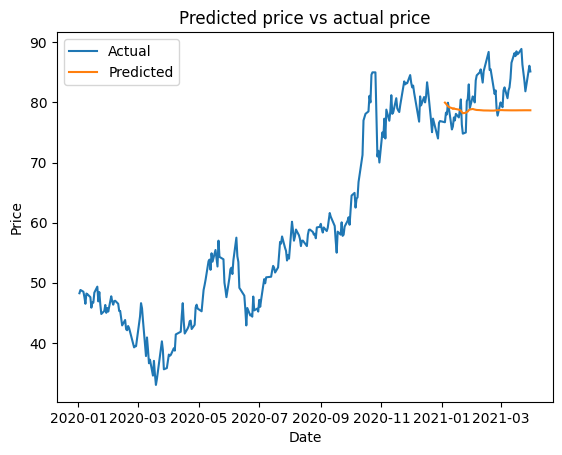

In [26]:
plt.figure()
plt.plot(df['Date'], df['Price'], label='Actual')
plt.plot(time_test, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted price vs actual price')
plt.legend()
plt.show()

## Modelling with RNN

To construct a model for the dataset, we firstly need to build a data pipe that could feed the input data to the model.

In [59]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[WINDOW_SIZE, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 20, 64)            256       
                                                                 
 lstm_14 (LSTM)              (None, 20, 64)            33024     
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_21 (Dense)            (None, 30)                1950      
                                                                 
 dense_22 (Dense)            (None, 10)                310       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-trai

In [60]:
history = model.fit(x=train_data, y=train_labels, epochs=100)

Epoch 1/100
7/7 [==============================] - 10s 30ms/step - loss: 56.4641
Epoch 2/100
7/7 [==============================] - 0s 36ms/step - loss: 55.7020
Epoch 3/100
7/7 [==============================] - 0s 30ms/step - loss: 54.7768
Epoch 4/100
7/7 [==============================] - 0s 37ms/step - loss: 53.7092
Epoch 5/100
7/7 [==============================] - 0s 32ms/step - loss: 52.3927
Epoch 6/100
7/7 [==============================] - 0s 35ms/step - loss: 50.8230
Epoch 7/100
7/7 [==============================] - 0s 32ms/step - loss: 49.0255
Epoch 8/100
7/7 [==============================] - 0s 34ms/step - loss: 46.9615
Epoch 9/100
7/7 [==============================] - 0s 32ms/step - loss: 44.6959
Epoch 10/100
7/7 [==============================] - 0s 34ms/step - loss: 42.2383
Epoch 11/100
7/7 [==============================] - 0s 32ms/step - loss: 39.5935
Epoch 12/100
7/7 [==============================] - 0s 34ms/step - loss: 36.6745
Epoch 13/100
7/7 [==================

In [61]:
train_data[-1].shape

(20,)

In [55]:
model.predict(train_data[-1])

ValueError: ignored

In [ ]:
def pred_RNN(model, initial_window, output_length=60):
    y_pred = []
    window = initial_window
    for i in range(output_length):
      next_day = model.predict(window)
      

In [56]:
model.predict(test_data[0].reshape(-1, 1))

1/1 [==============================] - 0s 36ms/step


array([[18.571556],
       [18.604292],
       [18.574043],
       [18.553846],
       [18.561499],
       [18.530315],
       [18.388891],
       [18.51413 ],
       [18.471872],
       [18.511393],
       [18.486254],
       [18.51413 ],
       [18.575283],
       [18.54088 ],
       [18.395359],
       [18.32995 ],
       [18.404966],
       [18.292488],
       [18.382366],
       [18.392132]], dtype=float32)

In [37]:
def pred_RNN(series, window_size=WINDOW_SIZE, output_length=60):
  input = list(series[-window_size:])
  for i in range(output_length):
    y_pred.append(sum(y_pred[-window_size:])/window_size)

  return y_pred[-output_length:]

In [38]:
windows = []

for batch in list(test.as_numpy_iterator()):
  windows.append(batch[0])

test_inputs = np.vstack(windows)

In [39]:
y_pred = model.predict(test_inputs)

y_true = df.Price[idx_2021:].values.reshape(-1, 1)

print(f'MAE: {MAE(y_true, y_pred)}')

2/2 [==============================] - 1s 9ms/step
MAE: 3.4180735778808597


Now let's compare our prediction to the actual data.

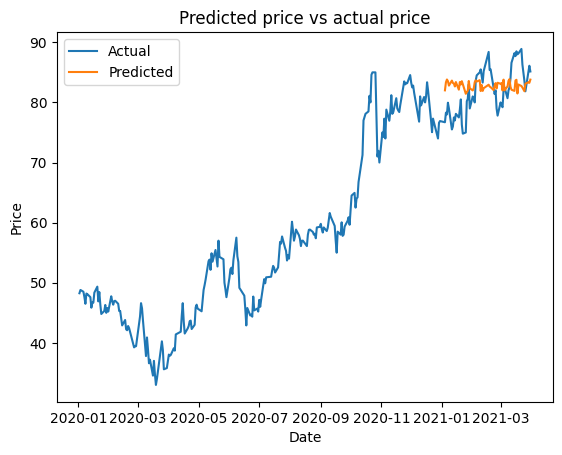

In [40]:
plt.figure()
plt.plot(df['Date'], df['Price'], label='Actual')
plt.plot(time_test, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted price vs actual price')
plt.legend()
plt.show()

## Modelling with Prophet

In [41]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from prophet import Prophet
m = Prophet(daily_seasonality=True)

temp_df = df[df['Date'].apply(lambda x: x.year < 2021)][['Date', 'Price']]
temp_df.rename({'Date': 'ds', 'Price': 'y'}, axis='columns', inplace=True)

m.fit(temp_df)
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
pd.options.display.max_columns = None
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1seuht9o/avhgrqaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1seuht9o/i82jep_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14097', 'data', 'file=/tmp/tmp1seuht9o/avhgrqaa.json', 'init=/tmp/tmp1seuht9o/i82jep_z.json', 'output', 'file=/tmp/tmp1seuht9o/prophet_modelhn8fjohd/prophet_model-20230601213021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds       yhat  yhat_lower  yhat_upper
295 2021-02-24  96.907434   91.471853  102.488023
296 2021-02-25  97.247680   91.631941  102.911213
297 2021-02-26  97.619165   92.293140  103.015517
298 2021-02-27  97.883537   92.564078  103.584746
299 2021-02-28  98.093486   92.699387  103.874518


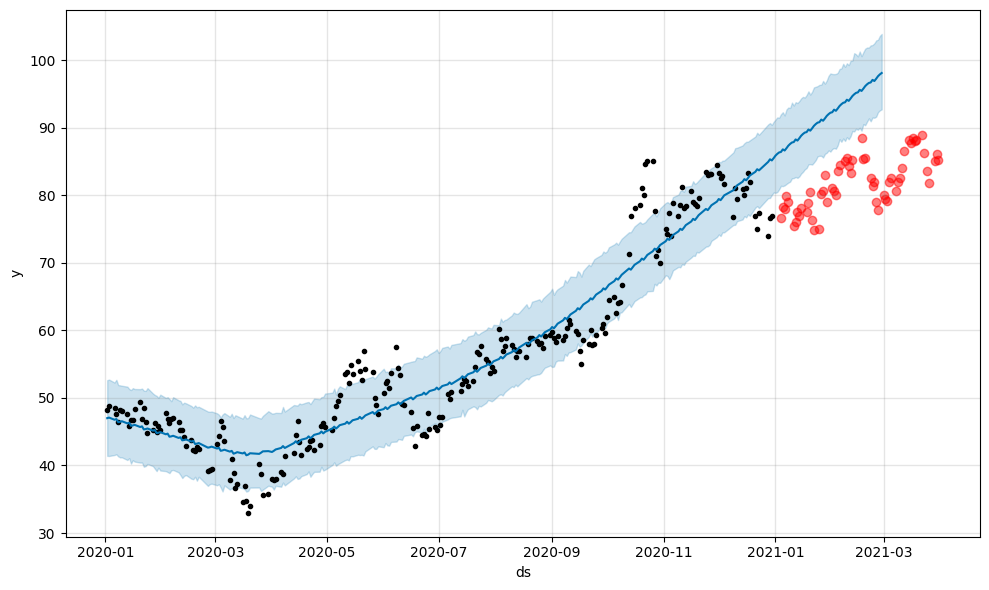

In [43]:
figure1 = m.plot(forecast)
plt.scatter(time_test, df['Price'][idx_2021:], color='red', alpha=0.5)